In [1]:
from google import colab
colab.drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Aimers_6th/aimers_data/

/content/drive/MyDrive/Colab Notebooks/Aimers_6th/aimers_data


In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

import warnings

warnings.filterwarnings('ignore')

import matplotlib.font_manager as fm

# 1️⃣ 나눔고딕 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum -qq > /dev/null

# 2️⃣ 폰트 경로 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# 3️⃣ 폰트 적용
fm.fontManager.addfont(font_path)  # 폰트 추가
plt.rc('font', family='NanumGothic')  # 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
pd.options.display.max_rows = None  # 모든 행 출력

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [109]:
train = pd.read_csv('./train.csv').drop(columns=['ID'])
test = pd.read_csv('./test.csv').drop(columns=['ID'])

train.shape, test.shape

((256351, 68), (90067, 67))

In [110]:
train.head()

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
1,TRYBLT,만45-50세,NaN,IVF,ICSI,0,알 수 없음,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
2,TRVNRY,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,2.0,NaN,0
3,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
4,TRVNRY,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0


In [111]:
train['임신 성공 여부'].value_counts()

,count
임신 성공 여부,
0,190123
1,66228


In [112]:
train.isnull().sum()

,0
시술 시기 코드,0
시술 당시 나이,0
임신 시도 또는 마지막 임신 경과 연수,246981
시술 유형,0
특정 시술 유형,2
배란 자극 여부,0
배란 유도 유형,0
단일 배아 이식 여부,6291
착상 전 유전 검사 사용 여부,253633
착상 전 유전 진단 사용 여부,6291


In [113]:
train['배란 유도 유형'].value_counts()

,count
배란 유도 유형,
기록되지 않은 시행,194432
알 수 없음,61917
세트로타이드 (억제제),1
생식선 자극 호르몬,1


In [65]:
# drop_idx = train.loc[train['단일 배아 이식 여부'].isnull()].index.tolist()
# train.drop(index=drop_idx, inplace=True)

In [85]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형',  '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']
#                 # , '남성 부 불임 원인','여성 부 불임 원인', '부부 부 불임 원인',
#                 #                                                        '불임 원인 - 정자 농도','불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성','불임 원인 - 정자 형태']

# train.drop(columns=drop_columns, inplace=True)
# test.drop(columns=drop_columns, inplace=True)

# train.shape, test.shape

((256351, 59), (90067, 58))

In [114]:
drop_columns2 = []
for col in train.columns:
  print(train[col].value_counts())
  if len(train[col].value_counts()) == 1:
    drop_columns2.append(col)

시술 시기 코드
TRDQAZ    38969
TRCMWS    38090
TRYBLT    36713
TRVNRY    36173
TRJXFG    36031
TRZKPL    35544
TRXQMD    34831
Name: count, dtype: int64
시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64
임신 시도 또는 마지막 임신 경과 연수
7.0     1214
8.0     1176
9.0     1023
6.0      991
10.0     947
11.0     701
5.0      692
12.0     510
13.0     481
14.0     331
4.0      305
15.0     254
16.0     202
17.0     140
18.0     106
3.0       89
19.0      86
20.0      83
2.0       21
0.0       12
1.0        6
Name: count, dtype: int64
시술 유형
IVF    250060
DI       6291
Name: count, dtype: int64
특정 시술 유형
ICSI                                   122368
IVF                                     91755
Unknown                                 26939
IUI                                      6100
ICSI:ICSI                                2314
ICSI / BLASTOCYST                        1609
IVF / BLASTOCYST          

In [115]:
for col in test.columns:
  print(test[col].value_counts())

시술 시기 코드
TRDQAZ    13610
TRCMWS    13392
TRYBLT    12929
TRZKPL    12793
TRJXFG    12764
TRVNRY    12560
TRXQMD    12019
Name: count, dtype: int64
시술 당시 나이
만18-34세    36178
만35-37세    20211
만38-39세    13611
만40-42세    13266
만43-44세     4272
만45-50세     2413
알 수 없음       116
Name: count, dtype: int64
임신 시도 또는 마지막 임신 경과 연수
7.0     405
8.0     403
6.0     352
9.0     320
10.0    311
5.0     286
11.0    253
12.0    205
13.0    168
14.0    127
4.0     106
15.0     92
17.0     64
16.0     64
18.0     44
20.0     33
19.0     29
3.0      23
2.0       5
0.0       4
1.0       3
Name: count, dtype: int64
시술 유형
IVF    87891
DI      2176
Name: count, dtype: int64
특정 시술 유형
ICSI                                  43237
IVF                                   32350
Unknown                                9216
IUI                                    2112
ICSI:ICSI                               797
ICSI / BLASTOCYST                       584
IVF:IVF                                 406
IVF / BLASTOCYST        

In [116]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['착상 전 유전 검사 사용 여부', '불임 원인 - 여성 요인', 'PGD 시술 여부', 'PGS 시술 여부', '난자 채취 경과일']


((256351, 63), (90067, 62))

In [117]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수','DI 출산 횟수']
for col in cat_to_int_columns:
  train[col] = train[col].map(cat_to_int_dict)
  test[col] = test[col].map(cat_to_int_dict)

In [103]:
train.loc[train['불임 원인 - 정자 농도'] == 1]['임신 성공 여부'].value_counts()

,count
임신 성공 여부,
0,207
1,69


In [40]:
train.isnull().sum()

,0
시술 시기 코드,0
시술 당시 나이,0
임신 시도 또는 마지막 임신 경과 연수,246981
시술 유형,0
특정 시술 유형,2
배란 자극 여부,0
단일 배아 이식 여부,6291
착상 전 유전 진단 사용 여부,6291
남성 주 불임 원인,0
남성 부 불임 원인,0


In [104]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '특정 시술 유형',
       '배란 자극 여부', '배란 유도 유형', '단일 배아 이식 여부', '착상 전 유전 진단 사용 여부', '남성 주 불임 원인',
       '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인', '부부 부 불임 원인',
       '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애',
       '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '배아 생성 주요 이유',
       '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수',
       'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
       '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
       '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', '난자 해동 경과일',
       '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부'],
 

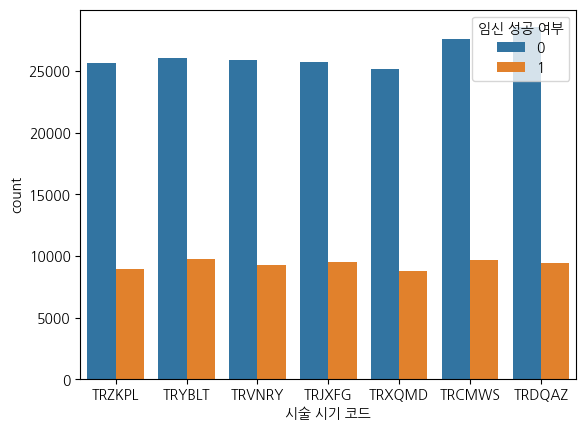

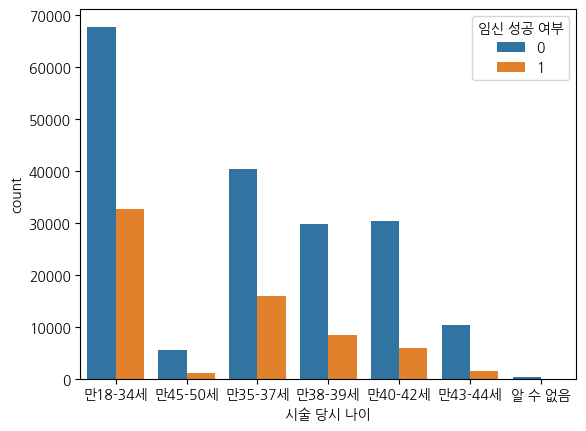

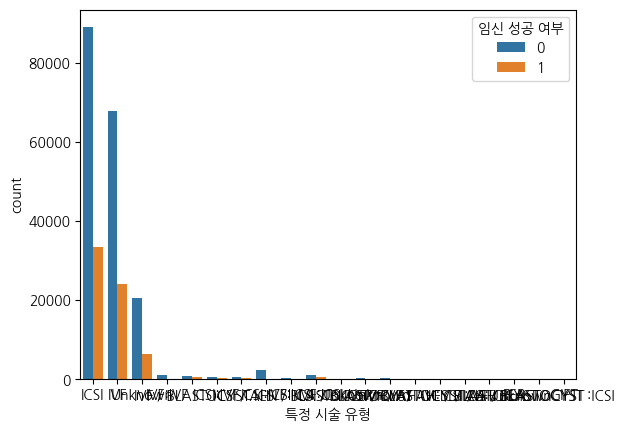

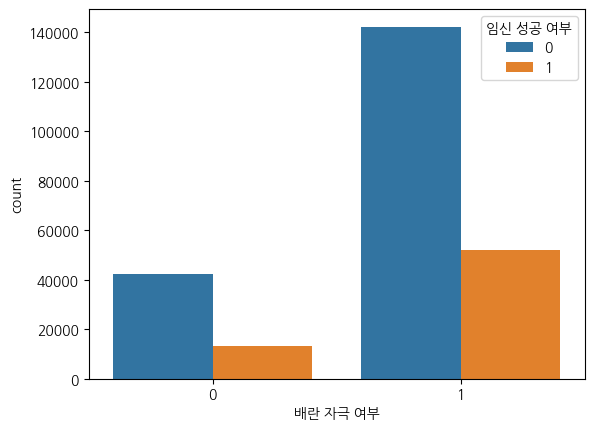

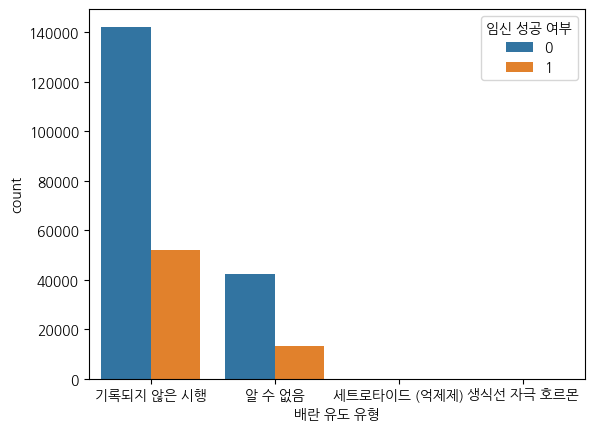

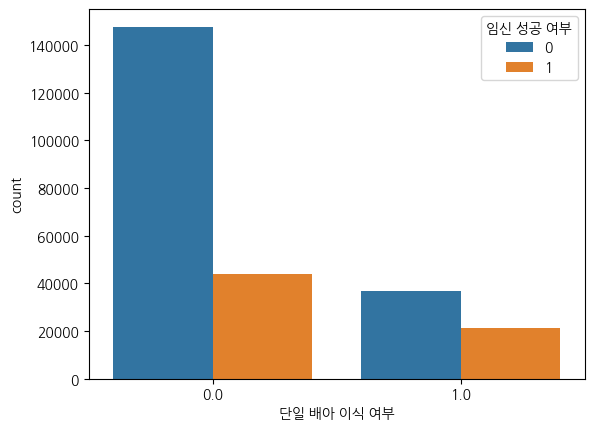

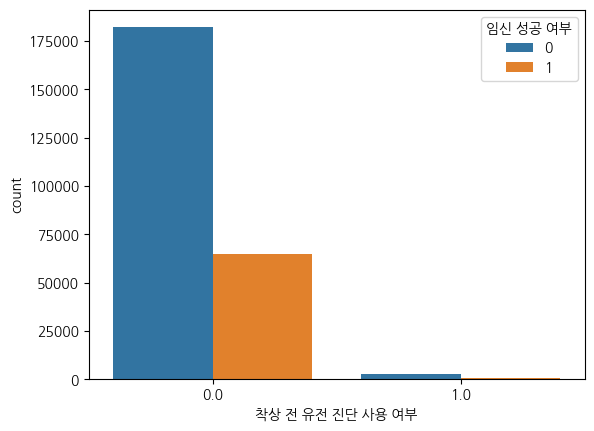

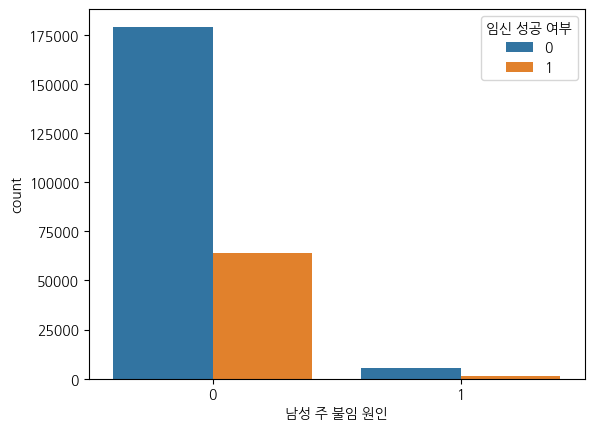

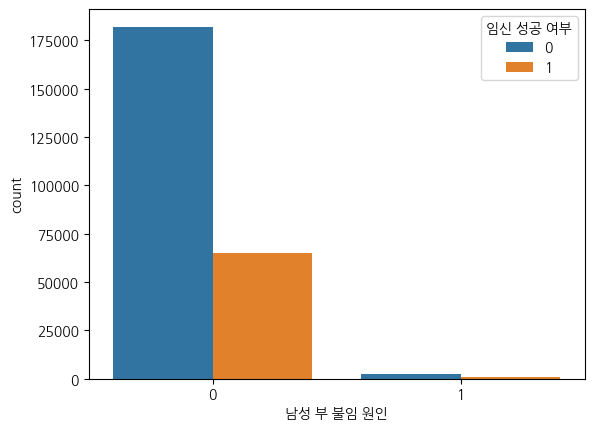

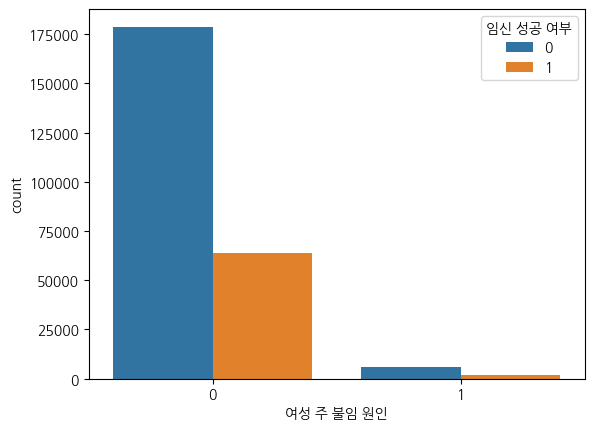

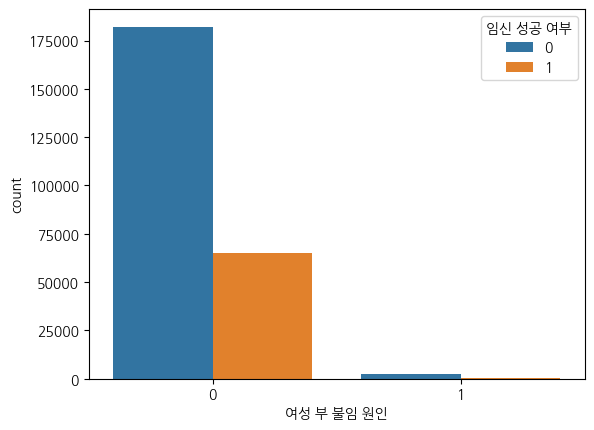

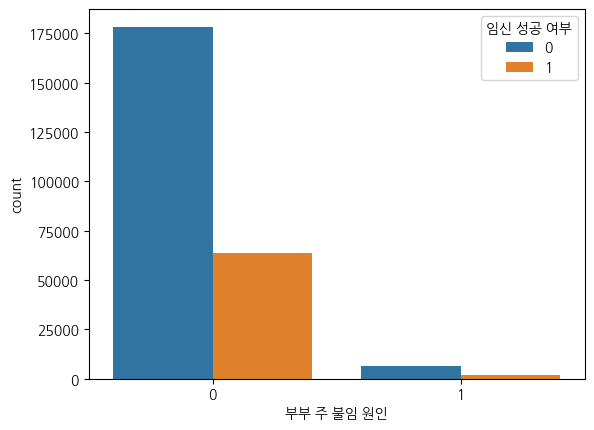

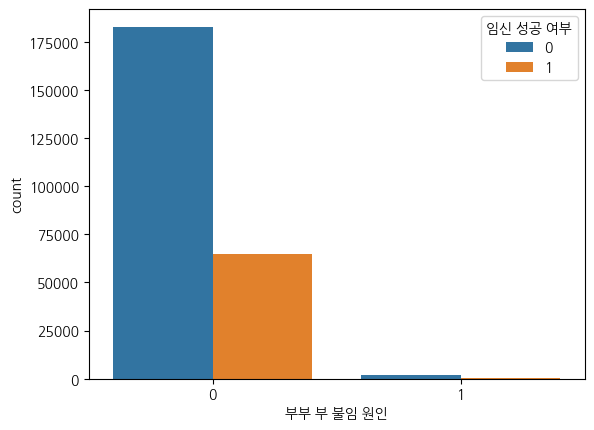

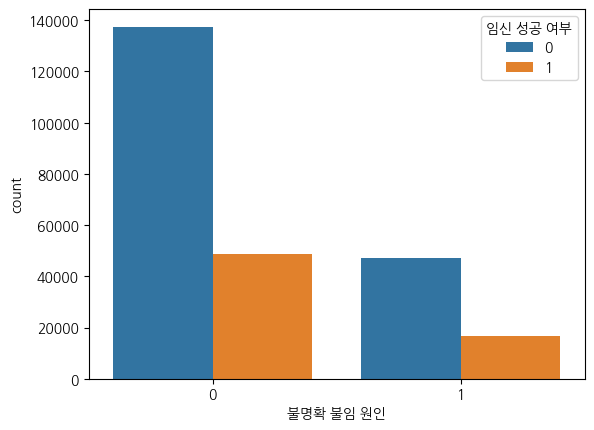

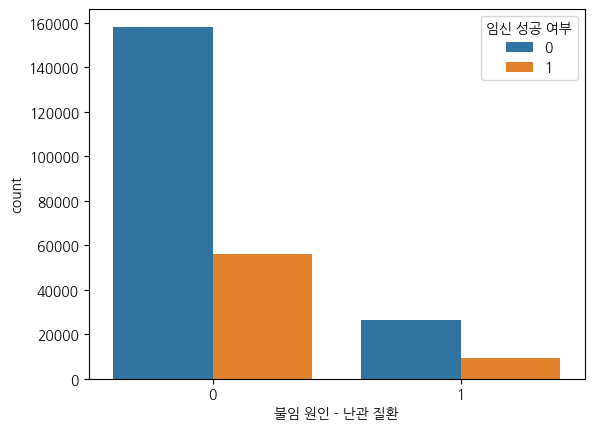

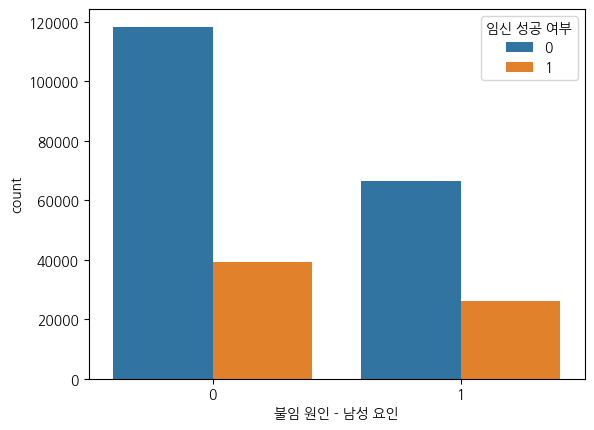

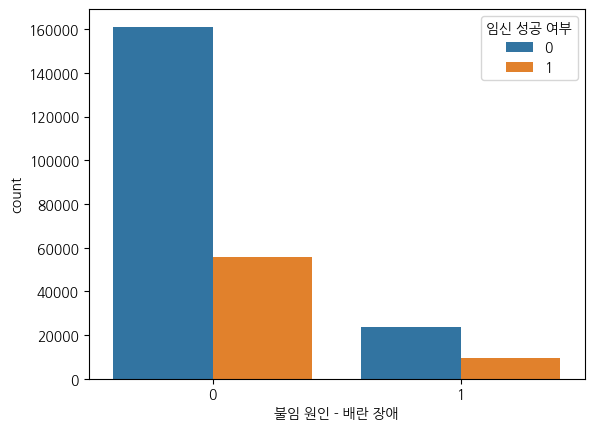

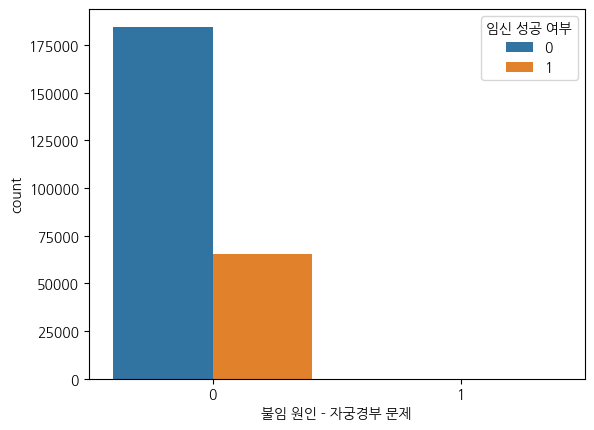

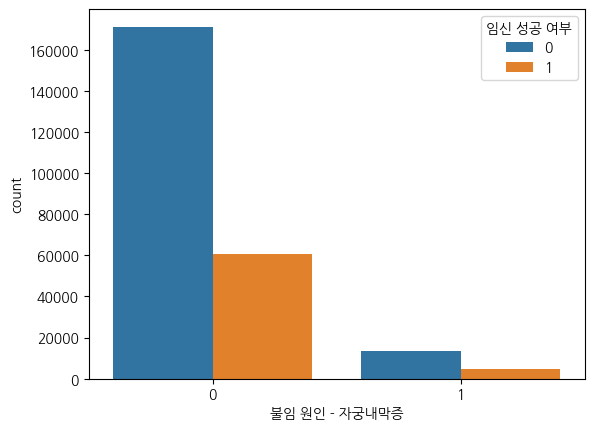

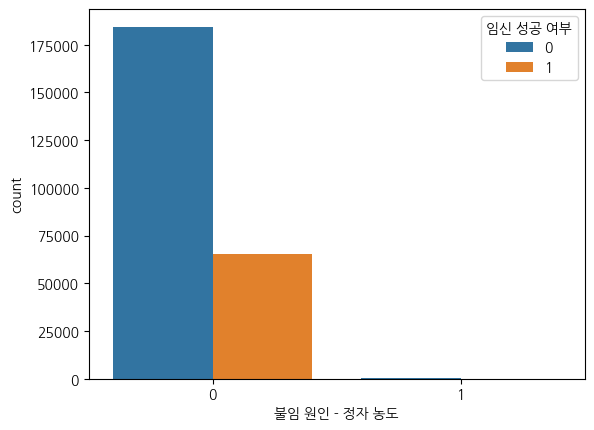

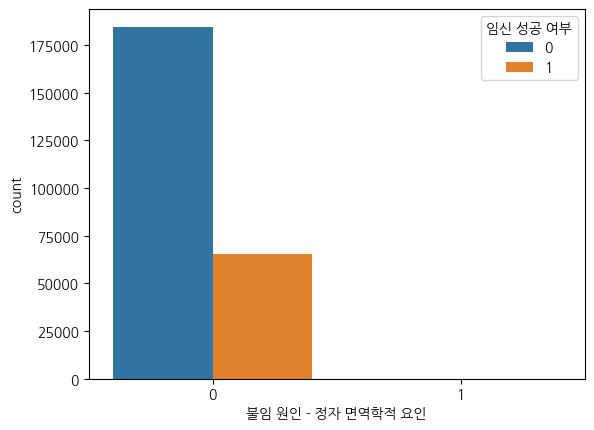

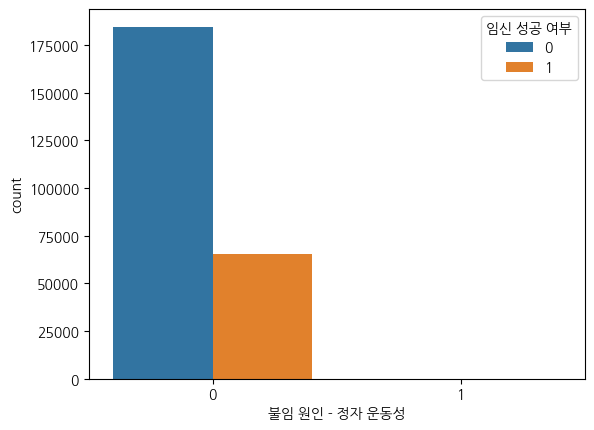

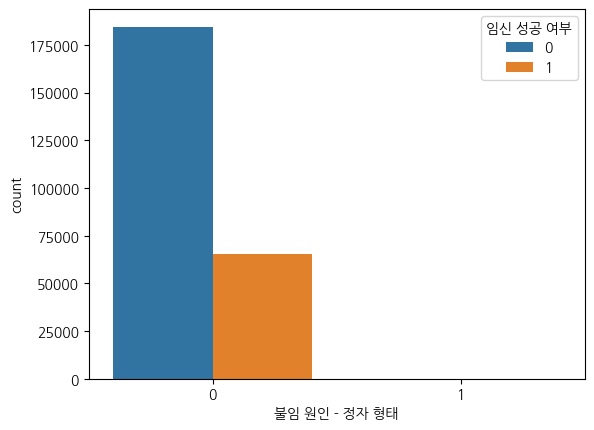

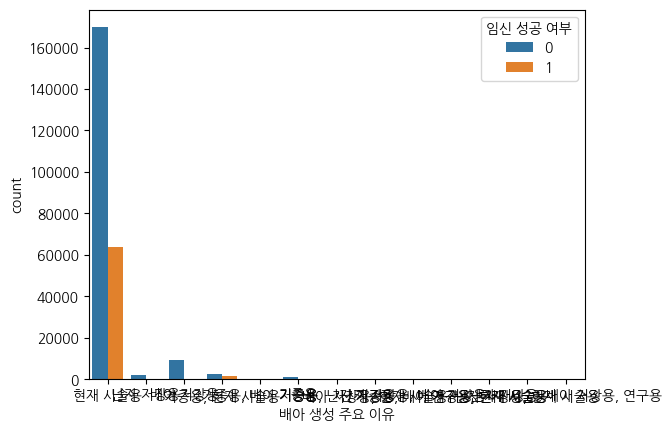

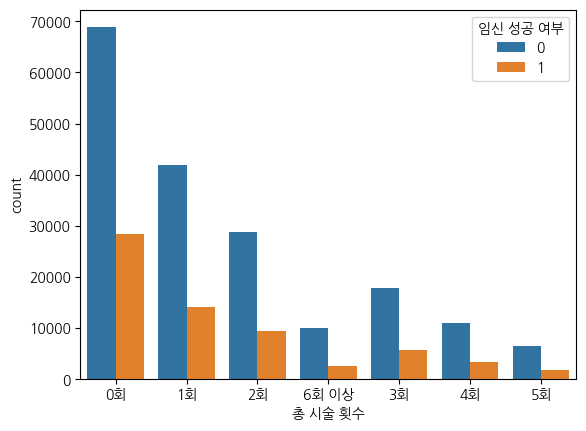

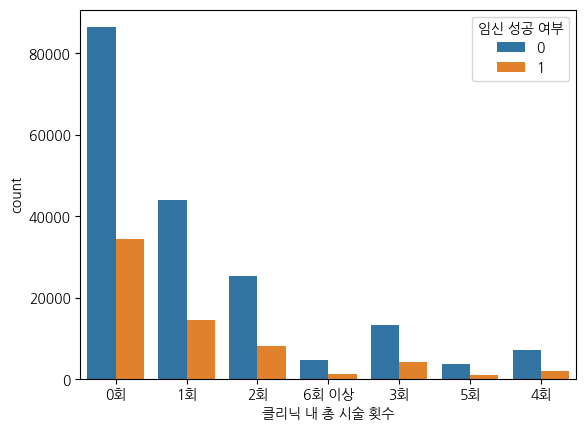

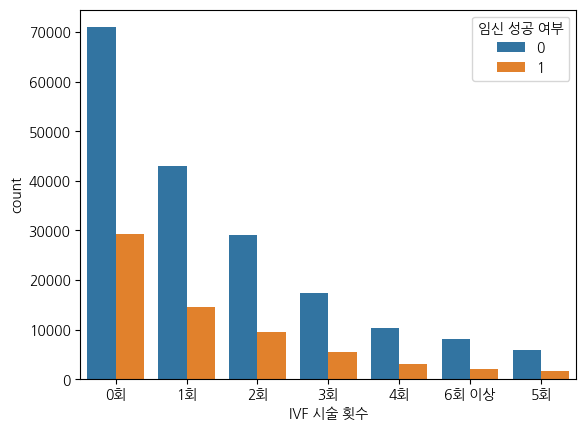

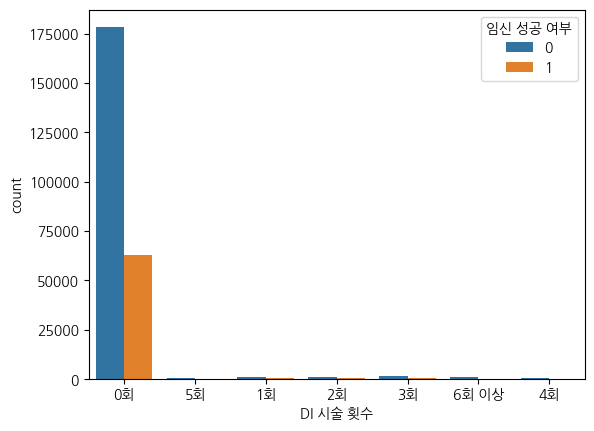

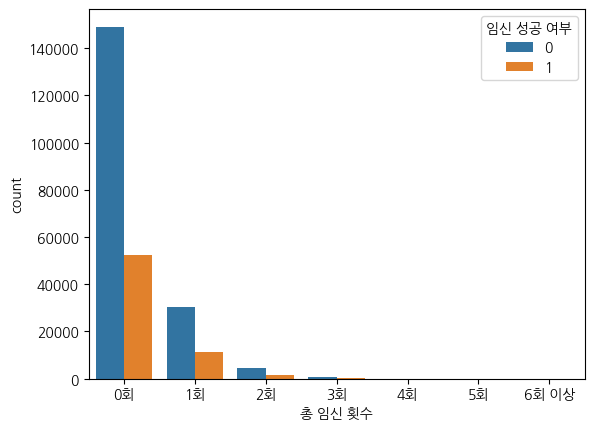

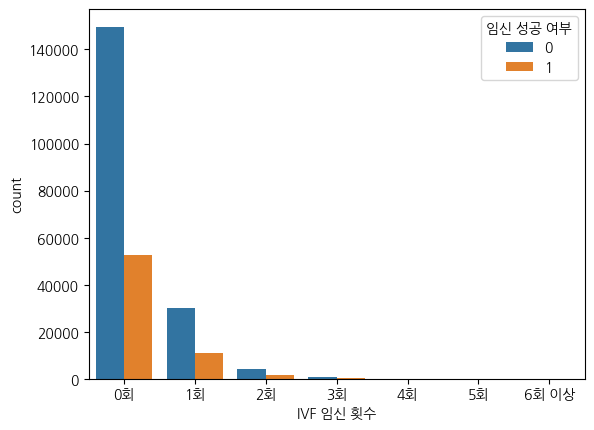

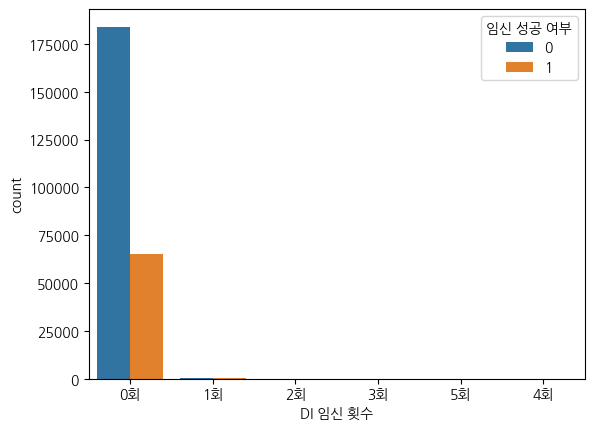

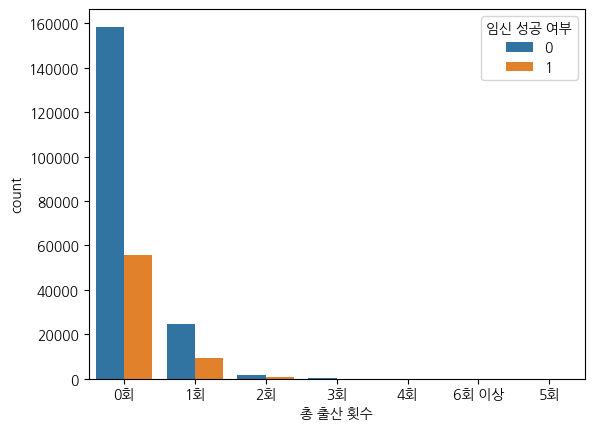

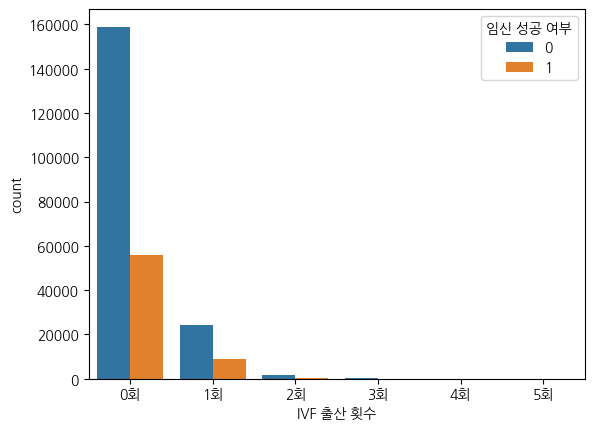

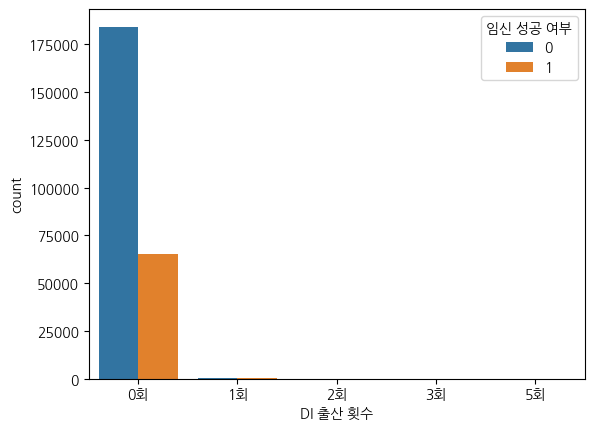

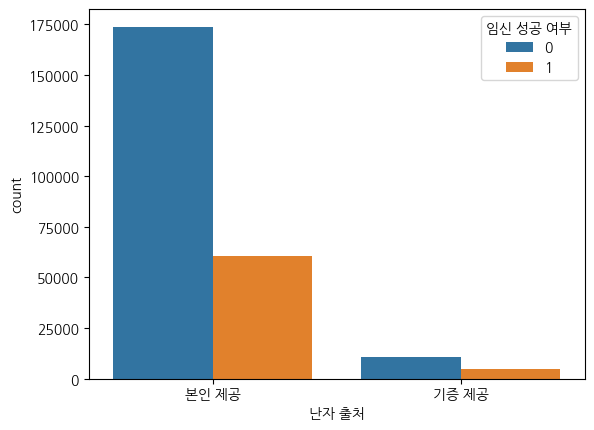

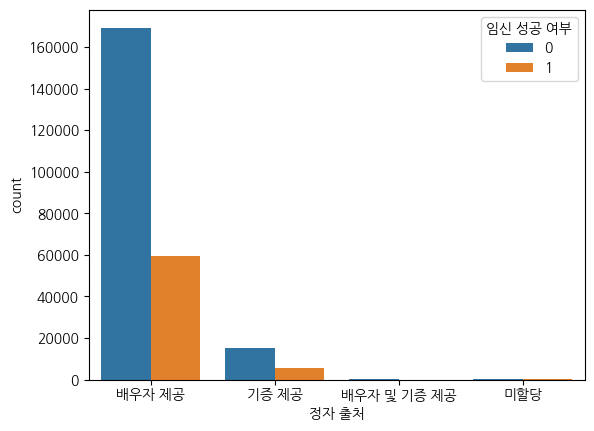

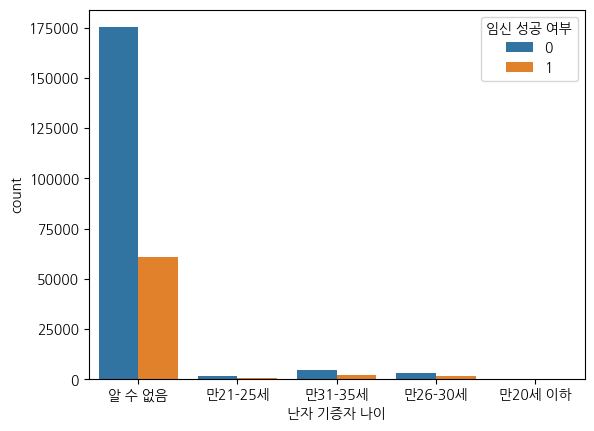

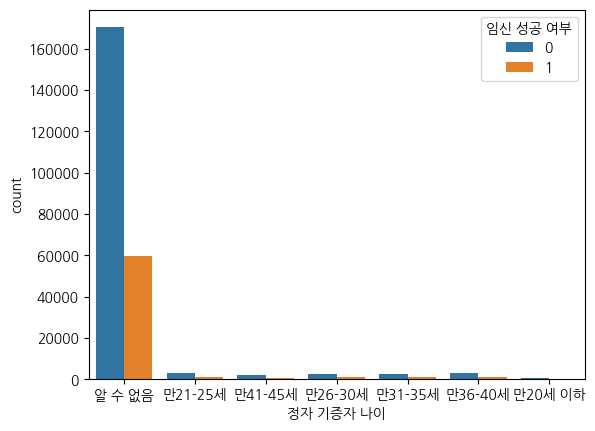

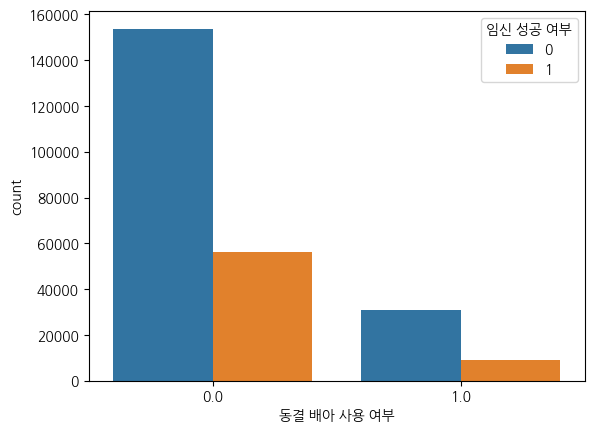

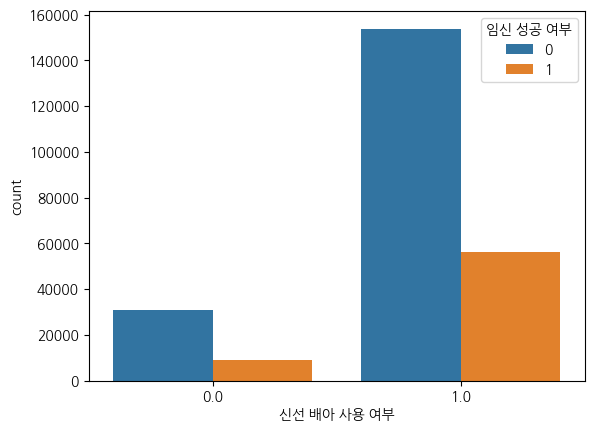

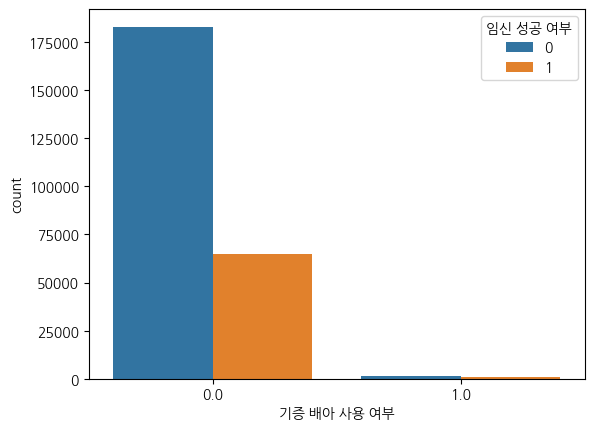

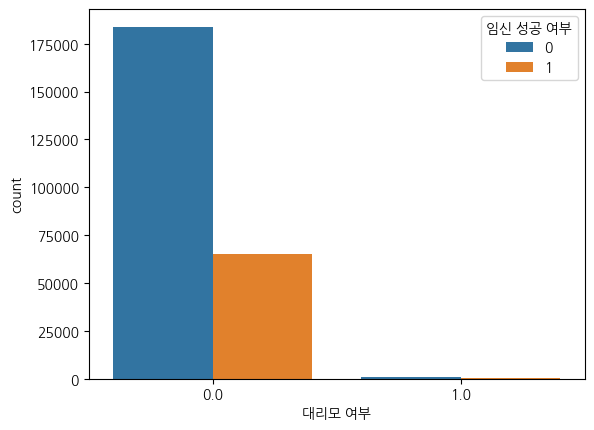

In [ ]:
# for cat_col in categorical_columns:
#   sns.countplot(data=train, x=cat_col, hue='임신 성공 여부')
#   plt.show()

In [ ]:
#corr_df = train[numeric_columns + ['임신 성공 여부']].corr()['임신 성공 여부']
# minus_corr_col = ['해동된 배아 수', '해동 난자 수', '저장된 신선 난자 수', '난자 혼합 경과일']
# train.drop(columns=minus_corr_col, inplace=True)
# test.drop(columns=minus_corr_col, inplace=True)

In [59]:
corr_df = train[numeric_columns + ['임신 성공 여부']].corr()['임신 성공 여부']
corr_df.sort_values(ascending=False)

,임신 성공 여부
임신 성공 여부,1.000000
이식된 배아 수,0.157487
배아 이식 경과일,0.148590
총 생성 배아 수,0.146116
혼합된 난자 수,0.116136
파트너 정자와 혼합된 난자 수,0.104902
미세주입에서 생성된 배아 수,0.090275
수집된 신선 난자 수,0.083023
미세주입 배아 이식 수,0.074351
미세주입된 난자 수,0.070117


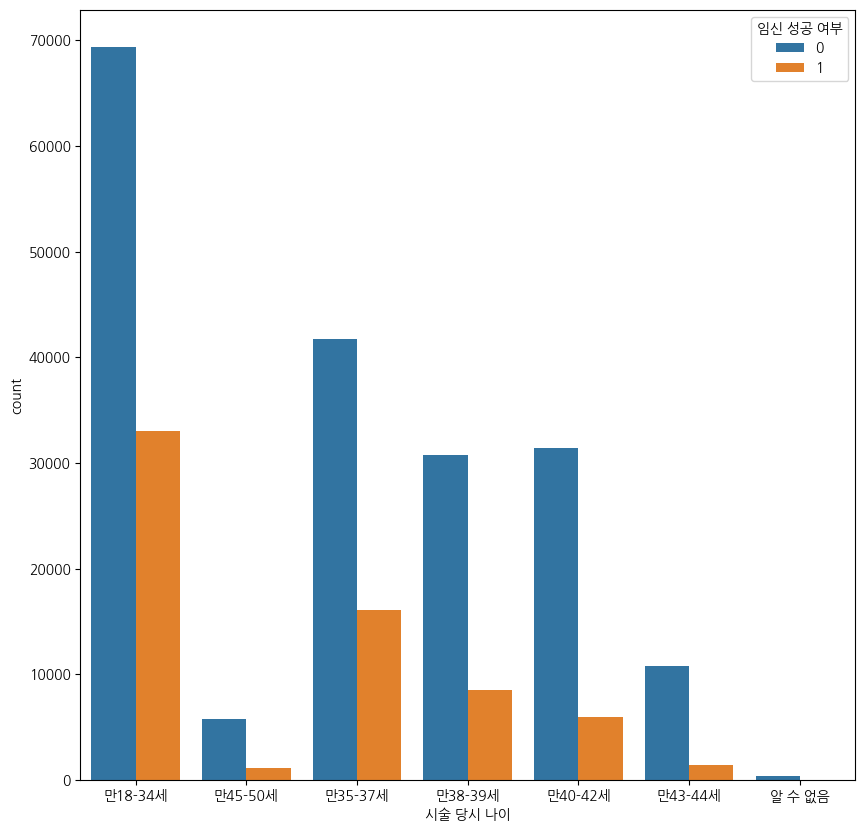

In [ ]:
plt.figure(figsize = (10,10))
sns.countplot(data = train, x = '시술 당시 나이', hue = '임신 성공 여부')
plt.show()

In [118]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                       "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                       "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                       "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                       "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁내막증","불임 원인 - 정자 농도",
                       "배아 생성 주요 이유","난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부",
                        '배란 유도 유형',  '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']


for col in categorical_columns:
    # mode_value = X[col].mode()[0]
    # X[col].fillna(mode_value, inplace=True)  # 결측치 대체
    # test[col].fillna(mode_value, inplace = True)

    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

numeric_columns = ["총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                       "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                   '임신 시도 또는 마지막 임신 경과 연수', "총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
                   "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
                   "해동된 배아 수","해동 난자 수","수집된 신선 난자 수","저장된 신선 난자 수","혼합된 난자 수",
                   "파트너 정자와 혼합된 난자 수","기증자 정자와 혼합된 난자 수",
                   '난자 해동 경과일', "난자 혼합 경과일","배아 이식 경과일", '배아 해동 경과일']

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
    mode_value = X[col].mode()[0]  # 최빈값 구하기
    X[col].fillna(mode_value, inplace=True)  # 결측치 대체
    test[col].fillna(mode_value, inplace = True)

In [119]:
def make_feature(df):
  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = df['미세주입에서 생성된 배아 수'] / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = df['미세주입 배아 이식 수'] / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = df['이식된 배아 수'] / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = df['저장된 배아 수'] / (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = df['해동된 배아 수'] / (df['저장된 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = df['파트너 정자와 혼합된 난자 수'] / (df['혼합된 난자 수'] + 1)
  #df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)

  df['임신 성공률'] = df['총 임신 횟수'] / (df['총 시술 횟수'] + 1)
  df['IVF 시술 성공률'] = df['IVF 임신 횟수'] / (df['IVF 시술 횟수'] + 1)
  df['DI 시술 성공률'] = df['DI 임신 횟수'] / (df['DI 시술 횟수'] + 1)
  # df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  # df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  # df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  # df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  return df

In [120]:
X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 71), (90067, 71))

In [121]:
test_pred_total = []
scores = []
cv = StratifiedKFold(n_splits = 10, random_state = 42, shuffle=True)

for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=42, task_type="GPU")
    model.fit(
        X_train,
        y_train,
        cat_features=categorical_columns,
        early_stopping_rounds= 300,
        eval_set=[(X_val,y_val)],
        verbose = 100
        )

    scores.append(model.get_best_score()["validation"]["AUC"])

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_total.append(test_pred)


Learning rate set to 0.04484


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7218004	best: 0.7218004 (0)	total: 63.3ms	remaining: 1m 3s
100:	test: 0.7410597	best: 0.7410597 (100)	total: 5.75s	remaining: 51.2s
200:	test: 0.7424455	best: 0.7424533 (196)	total: 11.7s	remaining: 46.6s
300:	test: 0.7429716	best: 0.7429716 (300)	total: 16.3s	remaining: 37.8s
400:	test: 0.7431564	best: 0.7432050 (382)	total: 23.2s	remaining: 34.7s
500:	test: 0.7433002	best: 0.7433234 (492)	total: 27.8s	remaining: 27.7s
600:	test: 0.7433770	best: 0.7433770 (600)	total: 33.9s	remaining: 22.5s
700:	test: 0.7433994	best: 0.7434860 (652)	total: 39.5s	remaining: 16.8s
800:	test: 0.7435102	best: 0.7435376 (797)	total: 44.1s	remaining: 10.9s
900:	test: 0.7435302	best: 0.7435656 (834)	total: 51.2s	remaining: 5.62s
999:	test: 0.7434722	best: 0.7435656 (834)	total: 55.6s	remaining: 0us
bestTest = 0.7435655594
bestIteration = 834
Shrink model to first 835 iterations.
Learning rate set to 0.04484


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7100819	best: 0.7100819 (0)	total: 107ms	remaining: 1m 47s
100:	test: 0.7299827	best: 0.7299827 (100)	total: 4.69s	remaining: 41.8s
200:	test: 0.7312937	best: 0.7313307 (190)	total: 9.2s	remaining: 36.6s
300:	test: 0.7319721	best: 0.7319721 (300)	total: 16.1s	remaining: 37.5s
400:	test: 0.7324271	best: 0.7324271 (400)	total: 20.7s	remaining: 30.9s
500:	test: 0.7326304	best: 0.7326462 (492)	total: 27.9s	remaining: 27.8s
600:	test: 0.7325514	best: 0.7326462 (492)	total: 32.5s	remaining: 21.6s
700:	test: 0.7323816	best: 0.7326462 (492)	total: 37s	remaining: 15.8s
bestTest = 0.7326461971
bestIteration = 492
Shrink model to first 493 iterations.
Learning rate set to 0.04484


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7177975	best: 0.7177975 (0)	total: 84.7ms	remaining: 1m 24s
100:	test: 0.7354539	best: 0.7354539 (100)	total: 6.98s	remaining: 1m 2s
200:	test: 0.7378191	best: 0.7378191 (200)	total: 11.6s	remaining: 46.1s
300:	test: 0.7386145	best: 0.7386145 (300)	total: 16.2s	remaining: 37.6s
400:	test: 0.7390006	best: 0.7390172 (396)	total: 23.2s	remaining: 34.7s
500:	test: 0.7393662	best: 0.7393662 (500)	total: 27.8s	remaining: 27.7s
600:	test: 0.7395091	best: 0.7395091 (600)	total: 34.7s	remaining: 23.1s
700:	test: 0.7395328	best: 0.7395825 (689)	total: 39.3s	remaining: 16.7s
800:	test: 0.7397105	best: 0.7397105 (800)	total: 43.8s	remaining: 10.9s
900:	test: 0.7397986	best: 0.7397991 (899)	total: 50.8s	remaining: 5.58s
999:	test: 0.7397888	best: 0.7398621 (964)	total: 55.3s	remaining: 0us
bestTest = 0.7398620844
bestIteration = 964
Shrink model to first 965 iterations.
Learning rate set to 0.04484


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7256315	best: 0.7256315 (0)	total: 62.1ms	remaining: 1m 2s
100:	test: 0.7435009	best: 0.7435009 (100)	total: 4.76s	remaining: 42.3s
200:	test: 0.7459384	best: 0.7459384 (200)	total: 9.75s	remaining: 38.8s
300:	test: 0.7465506	best: 0.7465506 (300)	total: 16s	remaining: 37.1s
400:	test: 0.7467472	best: 0.7467735 (392)	total: 20.5s	remaining: 30.6s
500:	test: 0.7468573	best: 0.7468573 (500)	total: 27.5s	remaining: 27.4s
600:	test: 0.7467434	best: 0.7468772 (522)	total: 32.1s	remaining: 21.3s
700:	test: 0.7467983	best: 0.7468772 (522)	total: 36.7s	remaining: 15.6s
800:	test: 0.7468376	best: 0.7468772 (522)	total: 43.8s	remaining: 10.9s
bestTest = 0.7468771935
bestIteration = 522
Shrink model to first 523 iterations.
Learning rate set to 0.04484


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7206464	best: 0.7206464 (0)	total: 61.7ms	remaining: 1m 1s
100:	test: 0.7412193	best: 0.7412273 (99)	total: 6.85s	remaining: 1m 1s
200:	test: 0.7424686	best: 0.7424686 (200)	total: 11.4s	remaining: 45.3s
300:	test: 0.7428096	best: 0.7428099 (298)	total: 18.4s	remaining: 42.7s
400:	test: 0.7428603	best: 0.7428755 (392)	total: 22.9s	remaining: 34.2s
500:	test: 0.7429968	best: 0.7430348 (490)	total: 27.5s	remaining: 27.4s
600:	test: 0.7430369	best: 0.7430578 (586)	total: 34.6s	remaining: 23s
700:	test: 0.7428944	best: 0.7430745 (626)	total: 39.8s	remaining: 17s
800:	test: 0.7428717	best: 0.7430745 (626)	total: 46.8s	remaining: 11.6s
900:	test: 0.7428613	best: 0.7430745 (626)	total: 51.2s	remaining: 5.63s
bestTest = 0.7430745363
bestIteration = 626
Shrink model to first 627 iterations.
Learning rate set to 0.04484


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7123076	best: 0.7123076 (0)	total: 62ms	remaining: 1m 1s
100:	test: 0.7341307	best: 0.7341307 (100)	total: 4.67s	remaining: 41.5s
200:	test: 0.7358356	best: 0.7358356 (200)	total: 9.22s	remaining: 36.6s
300:	test: 0.7364219	best: 0.7364219 (300)	total: 16.1s	remaining: 37.4s
400:	test: 0.7366021	best: 0.7366192 (388)	total: 20.6s	remaining: 30.8s
500:	test: 0.7370561	best: 0.7370561 (500)	total: 27.1s	remaining: 27s
600:	test: 0.7372271	best: 0.7372385 (594)	total: 32s	remaining: 21.2s
700:	test: 0.7373314	best: 0.7373413 (690)	total: 36.6s	remaining: 15.6s
800:	test: 0.7374224	best: 0.7374392 (735)	total: 43.4s	remaining: 10.8s
900:	test: 0.7375290	best: 0.7375290 (900)	total: 48s	remaining: 5.27s
999:	test: 0.7374687	best: 0.7375296 (909)	total: 54.3s	remaining: 0us
bestTest = 0.7375295758
bestIteration = 909
Shrink model to first 910 iterations.
Learning rate set to 0.04484


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7160813	best: 0.7160813 (0)	total: 62.8ms	remaining: 1m 2s
100:	test: 0.7344391	best: 0.7344391 (100)	total: 4.67s	remaining: 41.6s
200:	test: 0.7357593	best: 0.7357593 (200)	total: 11.3s	remaining: 44.9s
300:	test: 0.7364199	best: 0.7364199 (300)	total: 16.8s	remaining: 39.1s
400:	test: 0.7366075	best: 0.7366093 (399)	total: 23.6s	remaining: 35.3s
500:	test: 0.7368833	best: 0.7368886 (499)	total: 28.2s	remaining: 28.1s
600:	test: 0.7368830	best: 0.7369395 (559)	total: 32.9s	remaining: 21.8s
700:	test: 0.7369750	best: 0.7370008 (654)	total: 39.5s	remaining: 16.9s
800:	test: 0.7369736	best: 0.7370008 (654)	total: 44s	remaining: 10.9s
900:	test: 0.7368922	best: 0.7370008 (654)	total: 50.8s	remaining: 5.58s
bestTest = 0.7370007932
bestIteration = 654
Shrink model to first 655 iterations.
Learning rate set to 0.04484


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7199914	best: 0.7199914 (0)	total: 63ms	remaining: 1m 2s
100:	test: 0.7382101	best: 0.7382101 (100)	total: 7.1s	remaining: 1m 3s
200:	test: 0.7395501	best: 0.7395501 (200)	total: 11.6s	remaining: 46.2s
300:	test: 0.7399583	best: 0.7399585 (293)	total: 17.3s	remaining: 40.1s
400:	test: 0.7399307	best: 0.7400383 (375)	total: 23s	remaining: 34.4s
500:	test: 0.7397951	best: 0.7400383 (375)	total: 27.5s	remaining: 27.4s
600:	test: 0.7397915	best: 0.7400383 (375)	total: 34s	remaining: 22.6s
bestTest = 0.7400383353
bestIteration = 375
Shrink model to first 376 iterations.
Learning rate set to 0.04484


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7128930	best: 0.7128930 (0)	total: 62.3ms	remaining: 1m 2s
100:	test: 0.7378487	best: 0.7378487 (100)	total: 7.3s	remaining: 1m 4s
200:	test: 0.7402366	best: 0.7402366 (200)	total: 11.9s	remaining: 47.1s
300:	test: 0.7409643	best: 0.7409643 (300)	total: 19s	remaining: 44s
400:	test: 0.7416051	best: 0.7416051 (400)	total: 23.5s	remaining: 35.1s
500:	test: 0.7418498	best: 0.7419250 (479)	total: 28.1s	remaining: 27.9s
600:	test: 0.7419542	best: 0.7420621 (565)	total: 34.9s	remaining: 23.2s
700:	test: 0.7420473	best: 0.7420621 (565)	total: 39.5s	remaining: 16.8s
800:	test: 0.7420636	best: 0.7421028 (786)	total: 46.4s	remaining: 11.5s
900:	test: 0.7419025	best: 0.7421028 (786)	total: 50.9s	remaining: 5.59s
999:	test: 0.7418659	best: 0.7421028 (786)	total: 55.4s	remaining: 0us
bestTest = 0.7421028018
bestIteration = 786
Shrink model to first 787 iterations.
Learning rate set to 0.04484


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192871	best: 0.7192871 (0)	total: 62.2ms	remaining: 1m 2s
100:	test: 0.7378165	best: 0.7378165 (100)	total: 4.7s	remaining: 41.8s
200:	test: 0.7397307	best: 0.7397307 (200)	total: 11.2s	remaining: 44.5s
300:	test: 0.7403078	best: 0.7403078 (300)	total: 15.8s	remaining: 36.7s
400:	test: 0.7404988	best: 0.7405424 (371)	total: 20.3s	remaining: 30.3s
500:	test: 0.7405598	best: 0.7405825 (495)	total: 27.1s	remaining: 27s
600:	test: 0.7407262	best: 0.7407368 (593)	total: 31.7s	remaining: 21.1s
700:	test: 0.7406247	best: 0.7407662 (660)	total: 37.5s	remaining: 16s
800:	test: 0.7405967	best: 0.7407662 (660)	total: 42.9s	remaining: 10.7s
900:	test: 0.7405992	best: 0.7407662 (660)	total: 47.4s	remaining: 5.21s
bestTest = 0.7407662272
bestIteration = 660
Shrink model to first 661 iterations.


In [ ]:
np.mean(scores) # column drop : 0.7401020914316178

0.740343776345253

In [123]:
np.mean(scores)

0.7403463304042817

In [23]:
test_pred_total = np.mean(test_pred_total, axis=0)

(array([13493.,  2432.,  3373.,  6309.,  9452., 13295., 16889., 15317.,
         9029.,   478.]),
 array([5.51982405e-04, 8.94641034e-02, 1.78376224e-01, 2.67288345e-01,
        3.56200466e-01, 4.45112587e-01, 5.34024708e-01, 6.22936829e-01,
        7.11848950e-01, 8.00761071e-01, 8.89673192e-01]),
 <BarContainer object of 10 artists>)

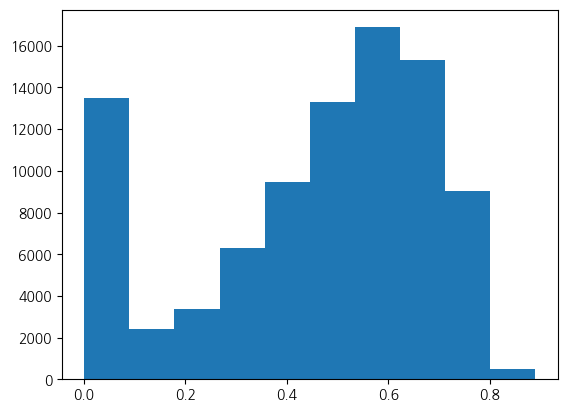

In [24]:
plt.hist(test_pred_total)

In [25]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission['probability'] = test_pred_total

In [26]:
sample_submission.to_csv('./Add_feature.csv', index=False)